In [1]:
# specify train, validation and test path 
train_dir = '/content/drive/MyDrive/MyProjects/garbage_img_classification/data/train'
val_dir = '/content/drive/MyDrive/MyProjects/garbage_img_classification/data/val'
test_dir = '/content/drive/MyDrive/MyProjects/garbage_img_classification/data/test'

# specify project directory in google drive
project_dir = '/content/drive/MyDrive/MyProjects/garbage_img_classification/'

# saved model name
model_name = 'best_pretrained_vgg16.h5'

# Garbage Image Classification

## Objective 
To classify type of garbage in an image.  
This dataset contains 6 types of garbage;  
- cardboard (393 images)  
- glass (491 images)  
- metal (400 images)  
- paper (584 images)  
- plastic (472 images)  
- trash (127 images)

## Dataset
source : https://www.kaggle.com/asdasdasasdas/garbage-classification

## Approach
Baseline model : 
- CNN model pre-trained VGG16 as a feature extractor (untrainable)  

Improved model with
- train last block of pre-trained VGG16
- data augmentation
- dropout layers

## Create Image Data Generator (without data augmentation)

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input

In [ ]:
# create data generator without data augmentation
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

batch_size = 20
train_iter = train_gen.flow_from_directory(train_dir,target_size=(128, 128), batch_size=batch_size, class_mode='categorical',seed=1)
val_iter = val_gen.flow_from_directory(val_dir,target_size=(128, 128), batch_size=batch_size, class_mode='categorical', seed=1)
test_iter = test_gen.flow_from_directory(test_dir,target_size=(128, 128), batch_size=1, class_mode='categorical')

Found 1768 images belonging to 6 classes.
Found 328 images belonging to 6 classes.
Found 431 images belonging to 6 classes.


## F-beta score function

In [3]:
from tensorflow.keras import backend

# optional sklearn.metrics.fbeta_score (cannot be used as training metric)
#from sklearn.metrics import fbeta_score

In [4]:
# I create F-beta score calculation in Keras to use as a metric 
# during training process instead of accuracy.

def fbeta(y_true, y_pred, beta=2):
  # clip predictions
  y_pred = backend.clip(y_pred, 0, 1)
  # calculate elements
  tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
  fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
  fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
  # calculate precision
  p = tp / (tp + fp + backend.epsilon())
  # calculate recall
  r = tp / (tp + fn + backend.epsilon())
  # calculate fbeta, averaged across each class
  bb = beta ** 2
  fbeta_score = backend.mean((1 + bb) * (p * r) / (bb * p + r + backend.epsilon()))
  return fbeta_score

## Evaluation function

In [5]:
import matplotlib.pyplot as plt

In [6]:
# create function for plotting

def evaluate_model(history):
    # plot training and validation loss
    fig = plt.figure(figsize=(15,5))
    fig.add_subplot(121)
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='val')
    plt.legend()
    plt.title('Loss')

    # plot training and validation accuracy
    fig.add_subplot(122)
    plt.plot(history.history['fbeta'], color='blue', label='train')
    plt.plot(history.history['val_fbeta'], color='orange', label='val')
    plt.legend()
    plt.title('F-beta score')
    
    plt.show()
    
    # print model accuracy
    _, fbeta = model.evaluate(test_iter, steps=len(test_iter), verbose=0)
    print('Model F-beta score : ', fbeta)
    return fbeta

## Baseline model : CNN with pre-trained VGG16

In [7]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# create model

# load VGG16 model
model = VGG16(include_top=False, input_shape=(128,128,3))
# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(100, activation='relu', kernel_initializer='he_uniform')(flat1)
output = Dense(6, activation='softmax')(class1)
# define model
model = Model(inputs=model.inputs, outputs=output)

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[fbeta])

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0   

Epoch 1/100
89/89 [==============================] - 1205s 13s/step - loss: 5.8337 - fbeta: 0.5567 - val_loss: 0.8549 - val_fbeta: 0.7044
Epoch 2/100
89/89 [==============================] - 9s 102ms/step - loss: 0.4162 - fbeta: 0.8565 - val_loss: 0.9259 - val_fbeta: 0.8015
Epoch 3/100
89/89 [==============================] - 9s 100ms/step - loss: 0.1171 - fbeta: 0.9577 - val_loss: 0.8968 - val_fbeta: 0.8353
Epoch 4/100
89/89 [==============================] - 9s 103ms/step - loss: 0.0378 - fbeta: 0.9905 - val_loss: 0.9397 - val_fbeta: 0.8250
Epoch 5/100
89/89 [==============================] - 9s 101ms/step - loss: 0.0237 - fbeta: 0.9904 - val_loss: 0.9240 - val_fbeta: 0.8074
Epoch 6/100
89/89 [==============================] - 9s 100ms/step - loss: 0.0336 - fbeta: 0.9903 - val_loss: 0.9500 - val_fbeta: 0.8221
Epoch 7/100
89/89 [==============================] - 9s 100ms/step - loss: 0.0154 - fbeta: 0.9961 - val_loss: 0.9749 - val_fbeta: 0.8265
Epoch 8/100
89/89 [=====================

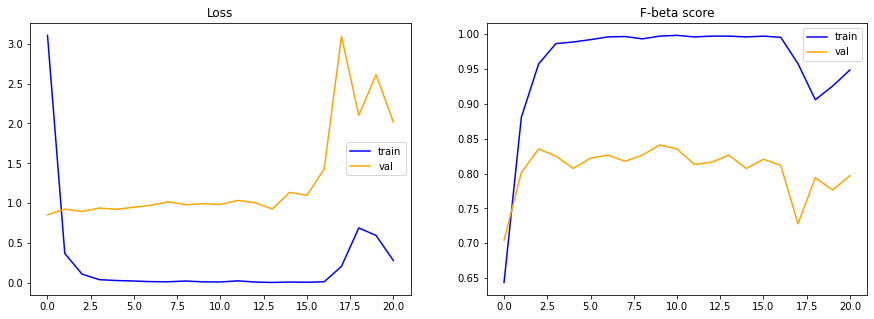

Model F-beta score :  0.7842226624488831


In [ ]:
# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# train model
history = model.fit(train_iter,
                    steps_per_epoch=len(train_iter), 
                    validation_data=val_iter,
                    validation_steps=len(val_iter),
                    callbacks=[es],
                    epochs=100)

# result
baseline_perf = evaluate_model(history)

Note : there is overfitting

## Improved Models

### model 1 : baseline + set last vgg block as trainable

Found 1768 images belonging to 6 classes.
Found 328 images belonging to 6 classes.
Found 431 images belonging to 6 classes.
Epoch 1/100
89/89 [==============================] - 10s 106ms/step - loss: 5.3969 - fbeta: 0.0888 - val_loss: 1.7689 - val_fbeta: 0.0000e+00
Epoch 2/100
89/89 [==============================] - 9s 104ms/step - loss: 1.8027 - fbeta: 0.0011 - val_loss: 1.7496 - val_fbeta: 0.0000e+00
Epoch 3/100
89/89 [==============================] - 9s 104ms/step - loss: 1.7514 - fbeta: 0.0000e+00 - val_loss: 1.7363 - val_fbeta: 0.0000e+00
Epoch 4/100
89/89 [==============================] - 9s 104ms/step - loss: 1.7414 - fbeta: 0.0000e+00 - val_loss: 1.7276 - val_fbeta: 0.0000e+00
Epoch 5/100
89/89 [==============================] - 9s 103ms/step - loss: 1.7296 - fbeta: 0.0000e+00 - val_loss: 1.7226 - val_fbeta: 0.0000e+00
Epoch 6/100
89/89 [==============================] - 9s 104ms/step - loss: 1.7298 - fbeta: 0.0000e+00 - val_loss: 1.7195 - val_fbeta: 0.0000e+00
Epoch 7/100
8

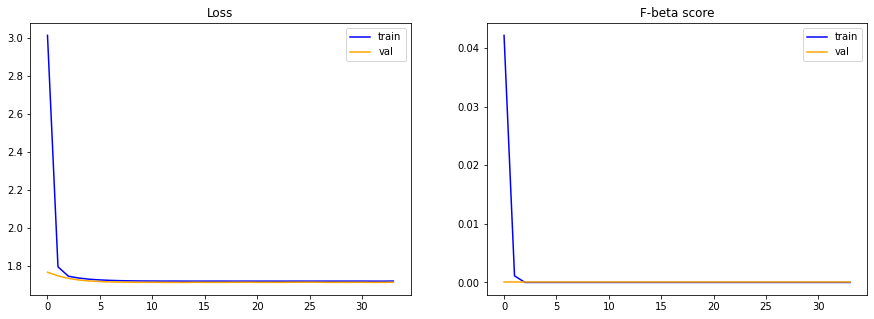

Model F-beta score :  0.0


In [ ]:
# create data generator without data augmentation
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

batch_size = 20
train_iter = train_gen.flow_from_directory(train_dir,target_size=(128, 128), batch_size=batch_size, class_mode='categorical',seed=1)
val_iter = val_gen.flow_from_directory(val_dir,target_size=(128, 128), batch_size=batch_size, class_mode='categorical', seed=1)
test_iter = test_gen.flow_from_directory(test_dir,target_size=(128, 128), batch_size=1, class_mode='categorical')

# create model
# load VGG16 model
model = VGG16(include_top=False, input_shape=(128,128,3))
# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False
# mark last vgg block as trainable
model.get_layer('block5_conv1').trainable = True
model.get_layer('block5_conv2').trainable = True
model.get_layer('block5_conv3').trainable = True
model.get_layer('block5_pool').trainable = True
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(100, activation='relu', kernel_initializer='he_uniform')(flat1)
output = Dense(6, activation='softmax')(class1)
# define model
model = Model(inputs=model.inputs, outputs=output)

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# train model
history = model.fit(train_iter,
                    steps_per_epoch=len(train_iter), 
                    validation_data=val_iter,
                    validation_steps=len(val_iter),
                    callbacks=[es],
                    epochs=100)

# result
model1_perf = evaluate_model(history)

Note : model learns very slow

### model 2 : Baseline + dropout layer

Found 1768 images belonging to 6 classes.
Found 328 images belonging to 6 classes.
Found 431 images belonging to 6 classes.
Epoch 1/100
89/89 [==============================] - 10s 102ms/step - loss: 6.6219 - fbeta: 0.4923 - val_loss: 0.9402 - val_fbeta: 0.5441
Epoch 2/100
89/89 [==============================] - 9s 100ms/step - loss: 0.7197 - fbeta: 0.6941 - val_loss: 0.7654 - val_fbeta: 0.7279
Epoch 3/100
89/89 [==============================] - 9s 100ms/step - loss: 0.5418 - fbeta: 0.7735 - val_loss: 0.8063 - val_fbeta: 0.7706
Epoch 4/100
89/89 [==============================] - 9s 100ms/step - loss: 0.4540 - fbeta: 0.8316 - val_loss: 0.7010 - val_fbeta: 0.7676
Epoch 5/100
89/89 [==============================] - 9s 100ms/step - loss: 0.3479 - fbeta: 0.8361 - val_loss: 0.8077 - val_fbeta: 0.7868
Epoch 6/100
89/89 [==============================] - 9s 100ms/step - loss: 0.3159 - fbeta: 0.8830 - val_loss: 0.7785 - val_fbeta: 0.7853
Epoch 7/100
89/89 [==============================] - 

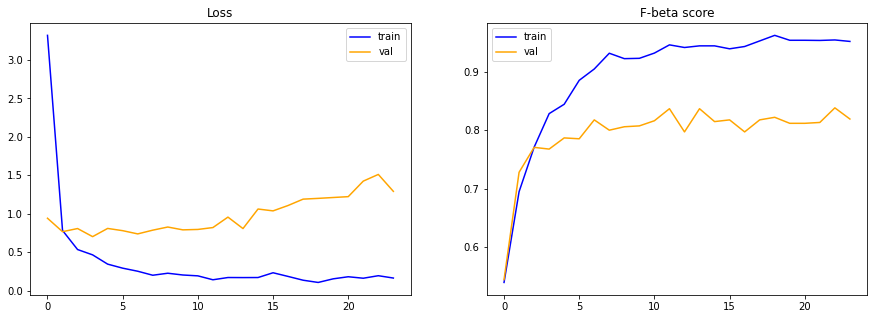

Model F-beta score :  0.8167052865028381


In [ ]:
# create data generator without data augmentation
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

batch_size = 20
train_iter = train_gen.flow_from_directory(train_dir,target_size=(128, 128), batch_size=batch_size, class_mode='categorical',seed=1)
val_iter = val_gen.flow_from_directory(val_dir,target_size=(128, 128), batch_size=batch_size, class_mode='categorical', seed=1)
test_iter = test_gen.flow_from_directory(test_dir,target_size=(128, 128), batch_size=1, class_mode='categorical')

# create model
# load VGG16 model
model = VGG16(include_top=False, input_shape=(128,128,3))
# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False
# add new classifier layers
dropout1 = Dropout(0.2)(model.layers[-1].output)
flat1 = Flatten()(dropout1)
class1 = Dense(100, activation='relu', kernel_initializer='he_uniform')(flat1)
dropout2 = Dropout(0.2)(class1)
output = Dense(6, activation='softmax')(dropout2)
# define model
model = Model(inputs=model.inputs, outputs=output)

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# train model
history = model.fit(train_iter,
                    steps_per_epoch=len(train_iter), 
                    validation_data=val_iter,
                    validation_steps=len(val_iter),
                    callbacks=[es],
                    epochs=100)

# result
model2_perf = evaluate_model(history)

Note : overfitting

### model 3 : Baseline + data augmentation

Found 1768 images belonging to 6 classes.
Found 328 images belonging to 6 classes.
Found 431 images belonging to 6 classes.
Epoch 1/100
89/89 [==============================] - 16s 173ms/step - loss: 6.0366 - fbeta: 0.4414 - val_loss: 1.3000 - val_fbeta: 0.4971
Epoch 2/100
89/89 [==============================] - 15s 164ms/step - loss: 1.1070 - fbeta: 0.5408 - val_loss: 1.1503 - val_fbeta: 0.5926
Epoch 3/100
89/89 [==============================] - 15s 163ms/step - loss: 0.9660 - fbeta: 0.5921 - val_loss: 0.9285 - val_fbeta: 0.6559
Epoch 4/100
89/89 [==============================] - 15s 165ms/step - loss: 0.8368 - fbeta: 0.6487 - val_loss: 0.9148 - val_fbeta: 0.6515
Epoch 5/100
89/89 [==============================] - 15s 165ms/step - loss: 0.7254 - fbeta: 0.6800 - val_loss: 1.0476 - val_fbeta: 0.6471
Epoch 6/100
89/89 [==============================] - 15s 164ms/step - loss: 0.6990 - fbeta: 0.7055 - val_loss: 0.8802 - val_fbeta: 0.6750
Epoch 7/100
89/89 [=============================

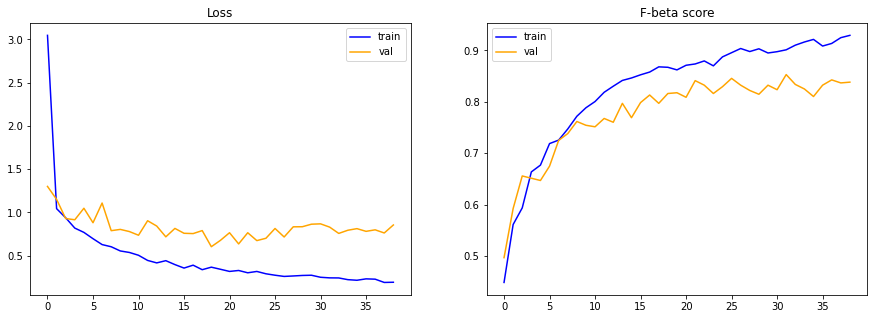

Model F-beta score :  0.819025456905365


In [ ]:
# create data generator without data augmentation
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range=0.2,
                               vertical_flip=True,
                               horizontal_flip=True)
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

batch_size = 20
train_iter = train_gen.flow_from_directory(train_dir,target_size=(128, 128), batch_size=batch_size, class_mode='categorical',seed=1)
val_iter = val_gen.flow_from_directory(val_dir,target_size=(128, 128), batch_size=batch_size, class_mode='categorical', seed=1)
test_iter = test_gen.flow_from_directory(test_dir,target_size=(128, 128), batch_size=1, class_mode='categorical')

# create model
# load VGG16 model
model = VGG16(include_top=False, input_shape=(128,128,3))
# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(100, activation='relu', kernel_initializer='he_uniform')(flat1)
output = Dense(6, activation='softmax')(class1)
# define model
model = Model(inputs=model.inputs, outputs=output)

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# train model
history = model.fit(train_iter,
                    steps_per_epoch=len(train_iter), 
                    validation_data=val_iter,
                    validation_steps=len(val_iter),
                    callbacks=[es],
                    epochs=100)

# result
model3_perf = evaluate_model(history)

Note : overfitting is reduced

### model 4 : Baseline + data augmentation + more dense layer

Found 1768 images belonging to 6 classes.
Found 328 images belonging to 6 classes.
Found 431 images belonging to 6 classes.
Epoch 1/100
89/89 [==============================] - 15s 164ms/step - loss: 6.3597 - fbeta: 0.4704 - val_loss: 1.4283 - val_fbeta: 0.6941
Epoch 2/100
89/89 [==============================] - 14s 162ms/step - loss: 1.2638 - fbeta: 0.6742 - val_loss: 1.3040 - val_fbeta: 0.7147
Epoch 3/100
89/89 [==============================] - 14s 160ms/step - loss: 1.1428 - fbeta: 0.6892 - val_loss: 0.8250 - val_fbeta: 0.7500
Epoch 4/100
89/89 [==============================] - 14s 161ms/step - loss: 0.8170 - fbeta: 0.7441 - val_loss: 0.9604 - val_fbeta: 0.7574
Epoch 5/100
89/89 [==============================] - 14s 160ms/step - loss: 0.6742 - fbeta: 0.7586 - val_loss: 0.7505 - val_fbeta: 0.7721
Epoch 6/100
89/89 [==============================] - 14s 161ms/step - loss: 0.5584 - fbeta: 0.8031 - val_loss: 0.7560 - val_fbeta: 0.7809
Epoch 7/100
89/89 [=============================

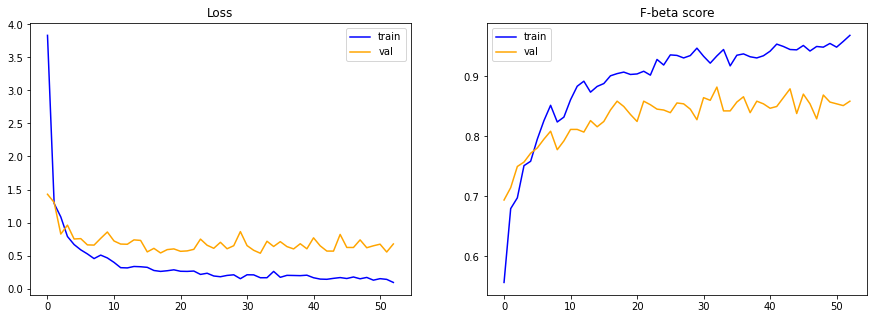

Model F-beta score :  0.8283061981201172


In [ ]:
# create data generator without data augmentation
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range=0.2,
                               vertical_flip=True,
                               horizontal_flip=True)
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

batch_size = 20
train_iter = train_gen.flow_from_directory(train_dir,target_size=(128, 128), batch_size=batch_size, class_mode='categorical',seed=1)
val_iter = val_gen.flow_from_directory(val_dir,target_size=(128, 128), batch_size=batch_size, class_mode='categorical', seed=1)
test_iter = test_gen.flow_from_directory(test_dir,target_size=(128, 128), batch_size=1, class_mode='categorical')

# create model
# load VGG16 model
model = VGG16(include_top=False, input_shape=(128,128,3))
# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(200, activation='relu', kernel_initializer='he_uniform')(flat1)
class2 = Dense(100, activation='relu', kernel_initializer='he_uniform')(class1)
output = Dense(6, activation='softmax')(class2)
# define model
model = Model(inputs=model.inputs, outputs=output)

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# train model
history = model.fit(train_iter,
                    steps_per_epoch=len(train_iter), 
                    validation_data=val_iter,
                    validation_steps=len(val_iter),
                    callbacks=[es],
                    epochs=100)

# result
model4_perf = evaluate_model(history)

Note : slight overfitting

### model 5 : Baseline + data augmentation + more dense layer + dropout layers

Found 1768 images belonging to 6 classes.
Found 328 images belonging to 6 classes.
Found 431 images belonging to 6 classes.
Epoch 1/100
89/89 [==============================] - 15s 164ms/step - loss: 9.6870 - fbeta: 0.3703 - val_loss: 2.1321 - val_fbeta: 0.6441
Epoch 2/100
89/89 [==============================] - 14s 160ms/step - loss: 2.5647 - fbeta: 0.5076 - val_loss: 1.0407 - val_fbeta: 0.6471
Epoch 3/100
89/89 [==============================] - 14s 162ms/step - loss: 1.4081 - fbeta: 0.5540 - val_loss: 0.9248 - val_fbeta: 0.6324
Epoch 4/100
89/89 [==============================] - 15s 163ms/step - loss: 1.3850 - fbeta: 0.5094 - val_loss: 0.9361 - val_fbeta: 0.5838
Epoch 5/100
89/89 [==============================] - 14s 159ms/step - loss: 1.1559 - fbeta: 0.5462 - val_loss: 0.7767 - val_fbeta: 0.6574
Epoch 6/100
89/89 [==============================] - 14s 160ms/step - loss: 0.9816 - fbeta: 0.5842 - val_loss: 0.9375 - val_fbeta: 0.6706
Epoch 7/100
89/89 [=============================

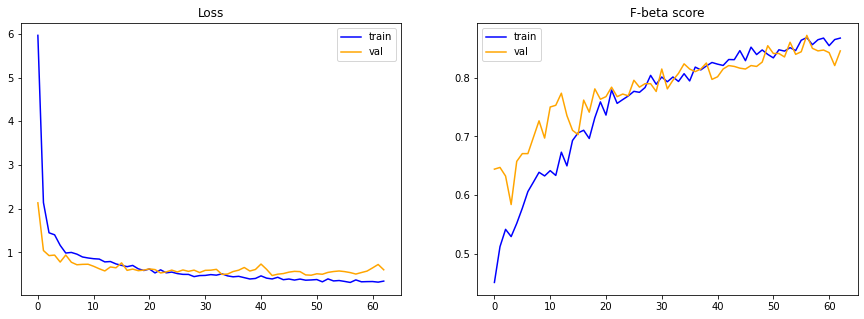

Model F-beta score :  0.8236657977104187


In [ ]:
# create data generator without data augmentation
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range=0.2,
                               vertical_flip=True,
                               horizontal_flip=True)
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

batch_size = 20
train_iter = train_gen.flow_from_directory(train_dir,target_size=(128, 128), batch_size=batch_size, class_mode='categorical',seed=1)
val_iter = val_gen.flow_from_directory(val_dir,target_size=(128, 128), batch_size=batch_size, class_mode='categorical', seed=1)
test_iter = test_gen.flow_from_directory(test_dir,target_size=(128, 128), batch_size=1, class_mode='categorical')

# create model
# load VGG16 model
model = VGG16(include_top=False, input_shape=(128,128,3))
# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False
# add new classifier layers
dropout1 = Dropout(0.2)(model.layers[-1].output)
flat1 = Flatten()(dropout1)
class1 = Dense(200, activation='relu', kernel_initializer='he_uniform')(flat1)
dropout2 = Dropout(0.2)(class1)
class2 = Dense(100, activation='relu', kernel_initializer='he_uniform')(dropout2)
dropout3 = Dropout(0.2)(class2)
output = Dense(6, activation='softmax')(dropout3)
# define model
model = Model(inputs=model.inputs, outputs=output)

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# train model
history = model.fit(train_iter,
                    steps_per_epoch=len(train_iter), 
                    validation_data=val_iter,
                    validation_steps=len(val_iter),
                    callbacks=[es],
                    epochs=100)

# result
model5_perf = evaluate_model(history)

Note : 

## Model performance :


In [ ]:
print('Baseline model : ', baseline_perf)
print('Model 1 : ', model1_perf)
print('Model 2 : ', model2_perf)
print('Model 3 : ', model3_perf)
print('Model 4 : ', model4_perf)
print('Model 5 : ', model5_perf)

Baseline model :  0.7842226624488831
Model 1 :  0.0
Model 2 :  0.8167052865028381
Model 3 :  0.819025456905365
Model 4 :  0.8283061981201172
Model 5 :  0.8236657977104187


Note : model 4 has overfitting, then I choose model 5 to be finalized

## Finalize the model
Train the selected model again.  
Give it more time to learn.  
Save the highest performance with ModelCheckpoint.


In [8]:
# create data generator without data augmentation
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range=0.2,
                               vertical_flip=True,
                               horizontal_flip=True)
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

batch_size = 20
train_iter = train_gen.flow_from_directory(train_dir,target_size=(128, 128), batch_size=batch_size, class_mode='categorical',seed=1)
val_iter = val_gen.flow_from_directory(val_dir,target_size=(128, 128), batch_size=batch_size, class_mode='categorical', seed=1)
test_iter = test_gen.flow_from_directory(test_dir,target_size=(128, 128), batch_size=1, class_mode='categorical', shuffle=False)

# create model
# load VGG16 model
model = VGG16(include_top=False, input_shape=(128,128,3))
# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False
# add new classifier layers
dropout1 = Dropout(0.2)(model.layers[-1].output)
flat1 = Flatten()(dropout1)
class1 = Dense(200, activation='relu', kernel_initializer='he_uniform')(flat1)
dropout2 = Dropout(0.2)(class1)
class2 = Dense(100, activation='relu', kernel_initializer='he_uniform')(dropout2)
dropout3 = Dropout(0.2)(class2)
output = Dense(6, activation='softmax')(dropout3)
# define model
model = Model(inputs=model.inputs, outputs=output)

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy')

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

# create model checkpoint
mc = ModelCheckpoint(model_name, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

# train model
history = model.fit(train_iter,
                    steps_per_epoch=len(train_iter), 
                    validation_data=val_iter,
                    validation_steps=len(val_iter),
                    callbacks=[es, mc],
                    epochs=300)

Found 1768 images belonging to 6 classes.
Found 328 images belonging to 6 classes.
Found 431 images belonging to 6 classes.
58892288/58889256 [==============================] - 1s 0us/step
Epoch 1/300
89/89 [==============================] - 771s 9s/step - loss: 8.4443 - val_loss: 1.4909

Epoch 00001: val_loss improved from inf to 1.49095, saving model to best_pretrained_vgg16.h5
Epoch 2/300
89/89 [==============================] - 15s 164ms/step - loss: 2.2984 - val_loss: 1.1433

Epoch 00002: val_loss improved from 1.49095 to 1.14331, saving model to best_pretrained_vgg16.h5
Epoch 3/300
89/89 [==============================] - 15s 164ms/step - loss: 1.7495 - val_loss: 0.9202

Epoch 00003: val_loss improved from 1.14331 to 0.92019, saving model to best_pretrained_vgg16.h5
Epoch 4/300
89/89 [==============================] - 15s 164ms/step - loss: 1.2057 - val_loss: 0.8586

Epoch 00004: val_loss improved from 0.92019 to 0.85859, saving model to best_pretrained_vgg16.h5
Epoch 5/300
89/89

In [10]:
# get y_true
y_true = test_iter.classes
# get one-hot encoded y_true 
from keras.utils import to_categorical
y_true = to_categorical(y_true)

# get y_pred
import numpy as np
prediction = model.predict(test_iter)
y_pred = np.rint(prediction)

# print model score
from sklearn.metrics import confusion_matrix, classification_report, fbeta_score
print('Confusion Matrix')
print(confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1)))
print('\nClassification Report')
print('\n', classification_report(y_true.argmax(axis=1), y_pred.argmax(axis=1)))
print('\nmodel f2 score : ', fbeta_score(y_true, y_pred, 2, average='samples'))

Confusion Matrix
[[66  0  0  3  0  1]
 [ 7 58  4  0 13  0]
 [ 1  4 61  1  1  0]
 [ 5  0  2 93  1  7]
 [ 3  4  2  1 63  1]
 [ 2  0  2  1  2 22]]

Classification Report

               precision    recall  f1-score   support

           0       0.79      0.94      0.86        70
           1       0.88      0.71      0.78        82
           2       0.86      0.90      0.88        68
           3       0.94      0.86      0.90       108
           4       0.79      0.85      0.82        74
           5       0.71      0.76      0.73        29

    accuracy                           0.84       431
   macro avg       0.83      0.84      0.83       431
weighted avg       0.85      0.84      0.84       431


model f2 score :  0.8352668213457076


In [11]:
!ls

best_pretrained_vgg16.h5  drive  sample_data


In [12]:
# copy saved model file to the project directory
import shutil

shutil.copyfile(model_name, project_dir+model_name)

'/content/drive/MyDrive/MyProjects/garbage_img_classification/best_pretrained_vgg16.h5'